Visualising high dimensional spaces using Bayesian GPLVM
--
*Alexis Boukouvalas, June 2016*

 - Sample from a periodic kernel
 - Visualise the space using Baysian GPLVM

In [1]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12,6)
matplotlib.style.use('ggplot')
%matplotlib inline
import GPflow
import numpy as np
import tensorflow as tf

In [2]:
Q = 2 # latent dimension
D = 5 # true dimension
N = 100
lengthscale = 11.5
variance = 1.3
rng = np.random.RandomState(1)
X_data1 = rng.multivariate_normal(np.zeros(D), 0.1*np.eye(D), N)
X_data2 = rng.multivariate_normal(2*np.ones(D), 1*np.eye(D), N)
X_data  = np.vstack([X_data1,X_data2])
idx = np.vstack([np.ones((N,1)), 2*np.ones((N,1))])
kernel = GPflow.kernels.RBF(Q, variance=variance, lengthscales=lengthscale)

In [3]:
x_free = tf.placeholder('float64')
kernel.make_tf_array(x_free)
X = tf.placeholder('float64')

with kernel.tf_mode():
    K = tf.Session().run(kernel.K(X),
                                   feed_dict={x_free: kernel.get_free_state(), X: X_data})
tol = 10e-6
L = np.linalg.cholesky(K + np.eye(K.shape[0])*tol)
Y=L.dot(np.random.randn(L.shape[0],D))

In [4]:
Y.shape

(200, 5)

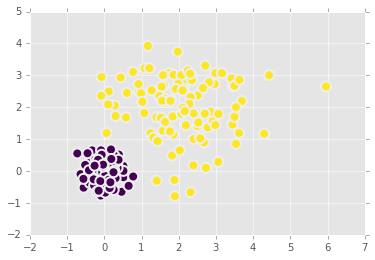

In [5]:
plt.scatter(X_data[:,0], X_data[:,1], 100, idx, lw=2, cmap=plt.cm.viridis)

(200, 2)


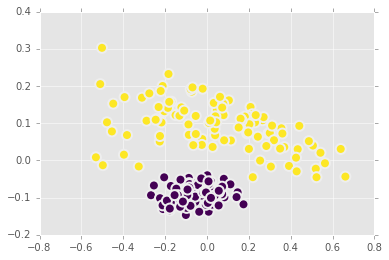

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=Q)
Xinit = pca.fit_transform(Y)
print Xinit.shape
plt.scatter(Xinit[:,0], Xinit[:,1], 100, idx, lw=2, cmap=plt.cm.viridis)

(10, 2)
compiling tensorflow function...
done
optimization terminated, setting model state


      fun: inf
 hess_inv: <821x821 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.10655116e+01,   1.75023305e-01,  -1.22037975e-01,
        -6.33500934e-01,  -1.87744032e-01,  -2.14589572e-01,
         4.45910207e-01,   1.22019105e-01,  -1.88153600e-01,
        -1.19712157e-01,   7.95900907e-02,  -6.94929441e-02,
        -5.19718626e-02,   2.80032934e-01,   2.17313087e-01,
        -6.12544765e-01,   3.50964477e-01,  -9.30421989e-02,
         2.59695311e-02,   9.87931234e-01,  -8.32903332e-01,
        -3.92205090e-01,  -4.07092877e-01,  -2.16872948e-02,
        -4.65678240e-01,  -3.77762385e-01,  -7.22135947e-01,
        -4.78535014e-01,  -5.13098234e-01,  -3.11583794e-01,
        -3.66820489e-01,  -4.79816575e-01,  -4.57211957e-01,
        -5.00876796e-01,  -4.97235032e-01,  -5.14832088e-01,
        -5.81626425e-01,  -5.26173781e-01,  -5.68819421e-01,
        -4.64092800e-01,  -3.94774182e-01,  -4.81943003e-01,
        -3.99337676e-01,  -4.51072146e-01,  -2.23128360e-01,

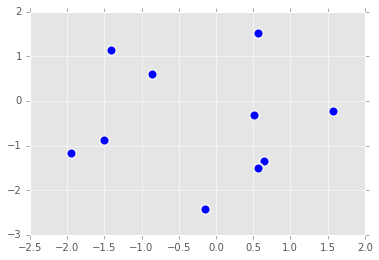

In [7]:
# Bayesian GPLVM model
from GPflow import gplvm

# Create 49 inducings points on a grid
fGrid = False
if(fGrid):
    Z1, Z2 = np.mgrid[X_data.min():X_data.max():7j, X_data.min():X_data.max():7j]
    Z = np.vstack([Z1.ravel(), Z2.ravel()]).T
else:
    Z = rng.multivariate_normal(np.zeros(Q), np.eye(Q), 10)

plt.scatter(Z[:,0], Z[:,1], 100, lw=2, cmap=plt.cm.viridis)

print Z.shape

# just optimize X
kernel.variance.fixed = True
kernel.lengthscales.fixed = True

# m = GPflow.gplvm.BayesianGPLVM(X_mean = np.zeros((2*N,Q)), 
#             X_var=np.ones((2*N,Q)), Y=Y, kern=kernel, Z=Z)

m = GPflow.gplvm.BayesianGPLVM(X_mean = Xinit,
                X_var=2*np.ones((2*N,Q)), Y=Y, kern=kernel, Z=Z)


m.optimize(max_iters = 33)

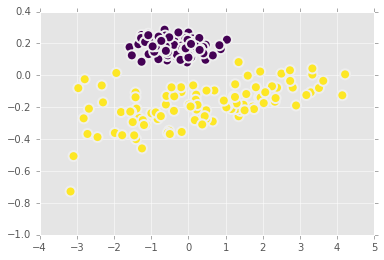

In [12]:
Xinf = m.X_mean._array
plt.scatter(Xinf[:,0], Xinf[:,1], 100, idx, lw=2, cmap=plt.cm.viridis)

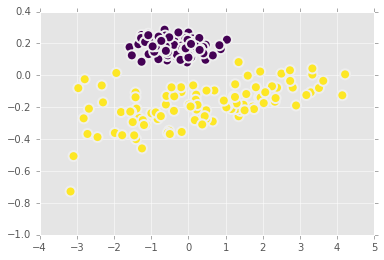

In [13]:
plt.scatter(Xinit[:,0], Xinit[:,1], 100, idx, lw=2, cmap=plt.cm.viridis)

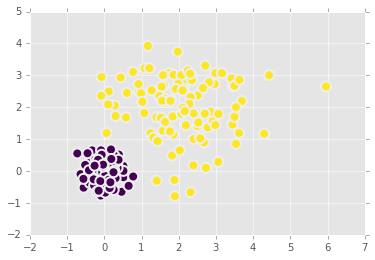

In [14]:
plt.scatter(X_data[:,0], X_data[:,1], 100, idx, lw=2, cmap=plt.cm.viridis)

In [18]:
# Has GPLVM done anything or is it stuck in initialisation?
np.allclose(Xinf,Xinit)

True